<a href="https://colab.research.google.com/github/ValentynaGrach/ml-homeworks/blob/main/%D0%94%D0%97__17_Time_series_ValentynaGrach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.26.4
!pip install darts prophet statsmodels

In [ ]:
import os

# Виводимо всі файли перед видаленням
print("📂 Вміст /content перед видаленням:")
print(os.listdir("/content/"))

# Видаляємо всі файли
for file_name in os.listdir("/content/"):
    file_path = os.path.join("/content/", file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
        print("🗑️ Файл", file_name, "успішно видалено.")

print("\n✅ Очистка завершена.")

📂 Вміст /content перед видаленням:
['.config', 'sample_data']

✅ Очистка завершена.


# 📌 1. Підготовка даних

In [ ]:
# Завантаження бібліотек до Colab
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import data_table
import datetime
from darts import TimeSeries
from darts.models import NaiveSeasonal
import statsmodels.api as sm

# Завантаження CSV-файлу
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Зчитування в DataFrame
frb = pd.read_csv(file_name)

# Вивід інформації
print("✅ Файл", file_name, "зчитано успішно. Розмір:", frb.shape)

# Попередній перегляд
print("\n📌 Перші рядки файлу:")
display(data_table.DataTable(frb.head()))

Saving T10Y2Y.csv to T10Y2Y.csv
✅ Файл T10Y2Y.csv зчитано успішно. Розмір: (2610, 2)

📌 Перші рядки файлу:


,date,T10Y2Y
0,2015-03-30,1.38
1,2015-03-31,1.38
2,2015-04-01,1.32
3,2015-04-02,1.37
4,2015-04-03,1.36


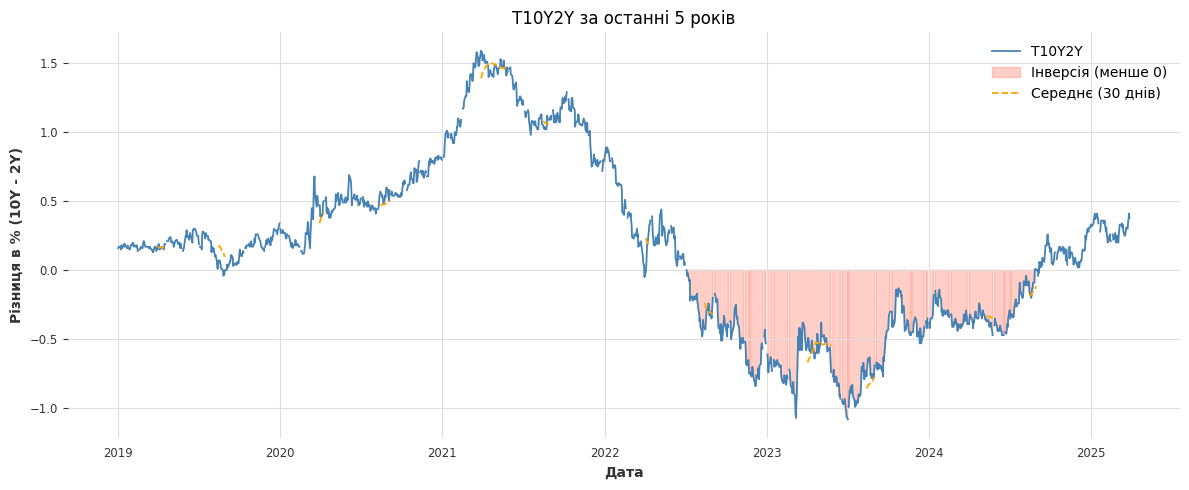

In [ ]:
# Перетворення дати у формат datetime
frb["date"] = pd.to_datetime(frb["date"])

# Створюємо копію з останніми 5 роками
cutoff_date = pd.Timestamp("2019-01-01")
frb_5y = frb[frb["date"] >= cutoff_date].copy()

# Додаємо скользяче середнє (30 днів)
frb_5y["SMA_30"] = frb_5y["T10Y2Y"].rolling(window=30).mean()

# Побудова графіка
plt.figure(figsize=(12, 5))
plt.plot(frb_5y["date"], frb_5y["T10Y2Y"], label="T10Y2Y", color="steelblue")
plt.fill_between(frb_5y["date"], frb_5y["T10Y2Y"], where=(frb_5y["T10Y2Y"] < 0), color='tomato', alpha=0.3, label="Інверсія (менше 0)")
plt.plot(frb_5y["date"], frb_5y["SMA_30"], label="Середнє (30 днів)", color="orange", linestyle="--")

plt.title("T10Y2Y за останні 5 років")
plt.xlabel("Дата")
plt.ylabel("Різниця в % (10Y - 2Y)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 **Аналіз графіка T10Y2Y (pandas: з ковзним середнім і зоною інверсії)**

📈 У 2020–2021 — поступове зростання показника до піку ~1.5%  
📉 У 2022–2023 — різке падіння та **інверсія**, тривала до 2024  
📈 Після цього — **повільне відновлення**, значення повертаються до позитивних  

📊 Ковзне середнє (30 днів) візуалізовано вручну  
📛 Інверсія (зона < 0) — підсвічена **помаранчевою заливкою**

✅ **Висновок:**  
Графік чітко і вручну відображає економічні фази: зростання → інверсія → відновлення.

---

# 🔍 2. Перетворення в TimeSeries

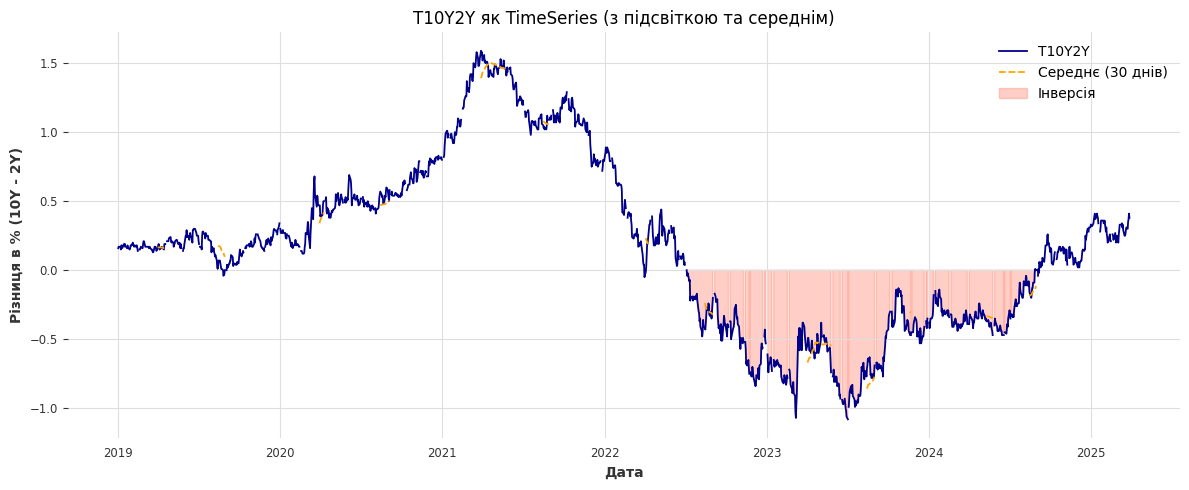

In [ ]:
# Створення TimeSeries об'єкта
series = TimeSeries.from_dataframe(frb_5y, time_col="date", value_cols="T10Y2Y")

# Побудова графіка
df_plot = series.to_dataframe()
plt.figure(figsize=(12, 5))
plt.plot(df_plot.index, df_plot["T10Y2Y"], label="T10Y2Y", color="darkblue")
df_plot["SMA_30"] = df_plot["T10Y2Y"].rolling(30).mean()
plt.plot(df_plot.index, df_plot["SMA_30"], label="Середнє (30 днів)", color="orange", linestyle="--")
plt.fill_between(df_plot.index, df_plot["T10Y2Y"], where=(df_plot["T10Y2Y"] < 0), color='tomato', alpha=0.3, label="Інверсія")
plt.title("T10Y2Y як TimeSeries (з підсвіткою та середнім)")
plt.xlabel("Дата")
plt.ylabel("Різниця в % (10Y - 2Y)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🔍 **Аналіз графіка T10Y2Y (TimeSeries: для моделювання)**

📈 У 2020–2021 — тренд до зростання  
📉 У 2022–2023 — глибока та затяжна **інверсія**, нижче 0  
📈 З 2024 — початок повільного підйому, але тренд ще нестабільний  

🔸 Ковзне середнє обчислено вже після створення TimeSeries  
🔸 Графік зручний для підготовки до моделей прогнозування

✅ **Висновок:**  
Цей графік не лише показує фази, а й служить стартовим пунктом для побудови моделей прогнозу.

---

In [ ]:
# Перевірка на пропущені значення у TimeSeries через DataFrame
df_check = series.to_dataframe()
missing_count = df_check.isna().sum().values[0]

if missing_count > 0:
    print("⚠️ Є пропущені значення:", missing_count)
    df_check = df_check.ffill()
    series = TimeSeries.from_dataframe(df_check)
    print("✅ Пропущені значення заповнені.")
else:
    print("✅ Немає пропущених значень.")

⚠️ Є пропущені значення: 68
✅ Пропущені значення заповнені.


✅ Ми заповнили 68 пропущених значень у часовому ряді методом **forward fill** — кожне значення було замінене попереднім ненульовим значенням.

# 🧪 3. Базовий прогноз

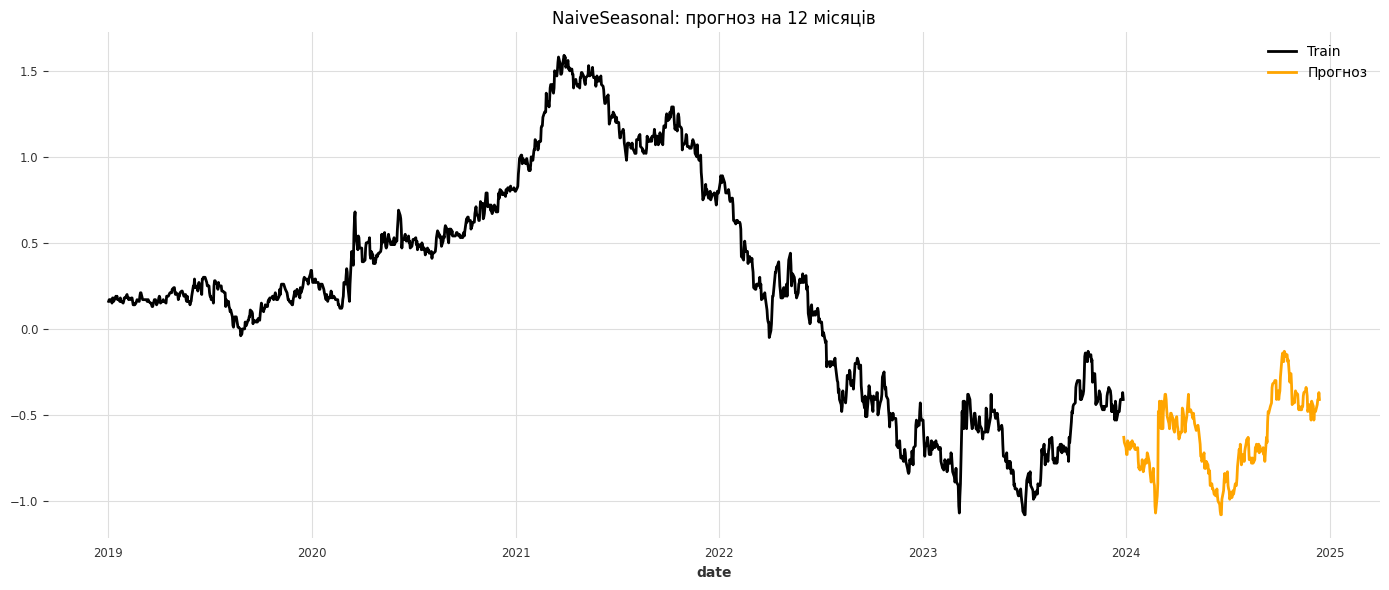

In [ ]:
# Розділяємо: 80% train, 20% test
train, test = series.split_before(0.8)

# Створення моделі з річною сезонністю
model = NaiveSeasonal(K=252)
model.fit(train)

# Прогноз на 12 місяців = 252 робочі дні
forecast = model.predict(252)

# Будуємо графік останніх 100 точок + прогноз
plt.figure(figsize=(14, 6))
train.plot(label="Train", lw=2)
forecast.plot(label="Прогноз", lw=2, color="orange")
plt.title("NaiveSeasonal: прогноз на 12 місяців")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🔍 Короткий аналіз:
- 🔁 **NaiveSeasonal** повторює сезонний шаблон з минулого року
- 📉 Прогноз не показує зміну тренду — просто “копіює” патерн

---

# 📊 4. Модель SARIMA

In [ ]:
# Вибираємо останні 3 роки (з 2022)
cutoff_date = pd.Timestamp("2023-01-01")
frb_short = frb[frb["date"] >= cutoff_date].copy()

# Підготовка даних
df_sarima = frb_short[["date", "T10Y2Y"]].copy()
df_sarima = df_sarima.rename(columns={"date": "date"})
df_sarima.set_index("date", inplace=True)
df_sarima.index.freq = "B"  # Business days

# Перевірка
print("📅 Остання дата:", df_sarima.index[-1])
print("📈 Кількість точок:", len(df_sarima))

📅 Остання дата: 2025-03-28 00:00:00
📈 Кількість точок: 585


In [ ]:
# Створюємо SARIMA-модель
model = sm.tsa.statespace.SARIMAX(
    df_sarima["T10Y2Y"],
    order=(1, 1, 1),               # (p, d, q)
    seasonal_order=(1, 1, 1, 63), # (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False)

# Навчаємо модель
print("⏳ Навчання моделі...")
results = model.fit(disp=False)
print("✅ Навчання завершено.")

⏳ Навчання моделі...
✅ Навчання завершено.


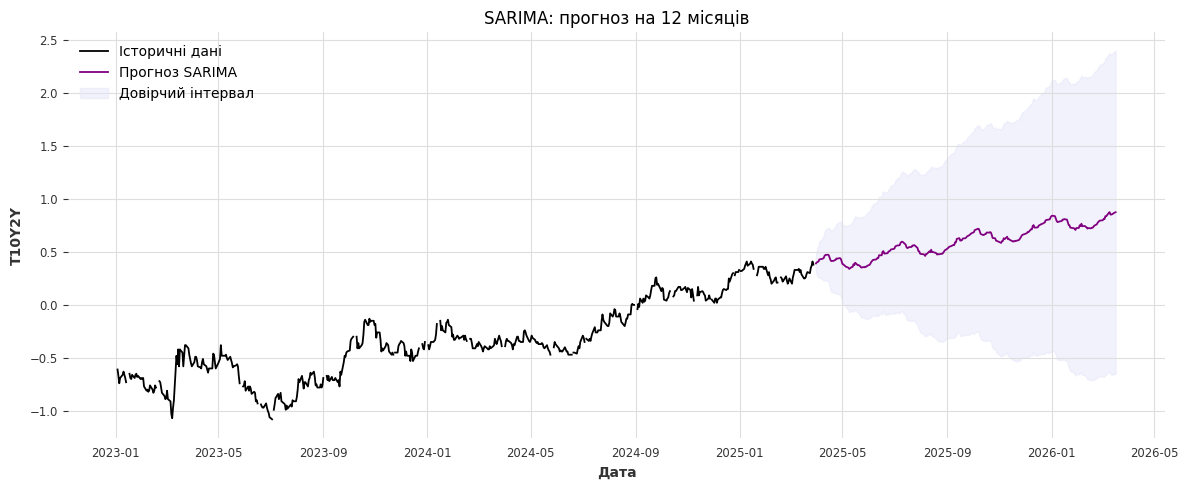

In [ ]:
# Прогноз на 252 точки вперед (≈ 12 місяців)
forecast = results.get_forecast(steps=252)
forecast_index = pd.date_range(
    start=df_sarima.index[-1],
    periods=252 + 1,
    freq="B")[1:]

forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Побудова графіка
plt.figure(figsize=(12, 5))
plt.plot(df_sarima.index, df_sarima["T10Y2Y"], label="Історичні дані")
plt.plot(forecast_index, forecast_values, label="Прогноз SARIMA", color="purple")
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color="lavender", alpha=0.5, label="Довірчий інтервал")
plt.title("SARIMA: прогноз на 12 місяців")
plt.xlabel("Дата")
plt.ylabel("T10Y2Y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🔍 **Аналіз SARIMA-прогнозу**  

📉 Історія: тренд зростає після 2023 року  
📈 Прогноз: плавне зростання, без стрибків  
🎯 Інтервал: ширший далі → більша невизначеність  

✅ **Висновок**: прогноз стабільний і логічний  
⏭ **Далі** → оцінка якості або порівняння з Prophet 🚀

# 🔮 5. Остаточний прогноз на майбутнє

In [ ]:
# Встановлення Prophet (якщо ще не встановлено)
!pip install prophet

# Імпортуємо бібліотеку Prophet
from prophet import Prophet

In [ ]:
# Підготовка даних — під вимоги Prophet
df_prophet = frb_5y[["date", "T10Y2Y"]].copy()
df_prophet = df_prophet.rename(columns={"date": "ds", "T10Y2Y": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
df_prophet["y"] = df_prophet["y"].ffill()

print("✅ Дані підготовлено: кількість рядків =", len(df_prophet))

✅ Дані підготовлено: кількість рядків = 1629


In [ ]:
# Створення та навчання моделі Prophet

model = Prophet()
print("⏳ Навчання моделі...")
model.fit(df_prophet)
print("✅ Модель Prophet навчено.")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp94hwtppm/fynidqvg.json


⏳ Навчання моделі...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp94hwtppm/r9f8iow3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24124', 'data', 'file=/tmp/tmp94hwtppm/fynidqvg.json', 'init=/tmp/tmp94hwtppm/r9f8iow3.json', 'output', 'file=/tmp/tmp94hwtppm/prophet_model0wpcndb7/prophet_model-20250331172152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Модель Prophet навчено.


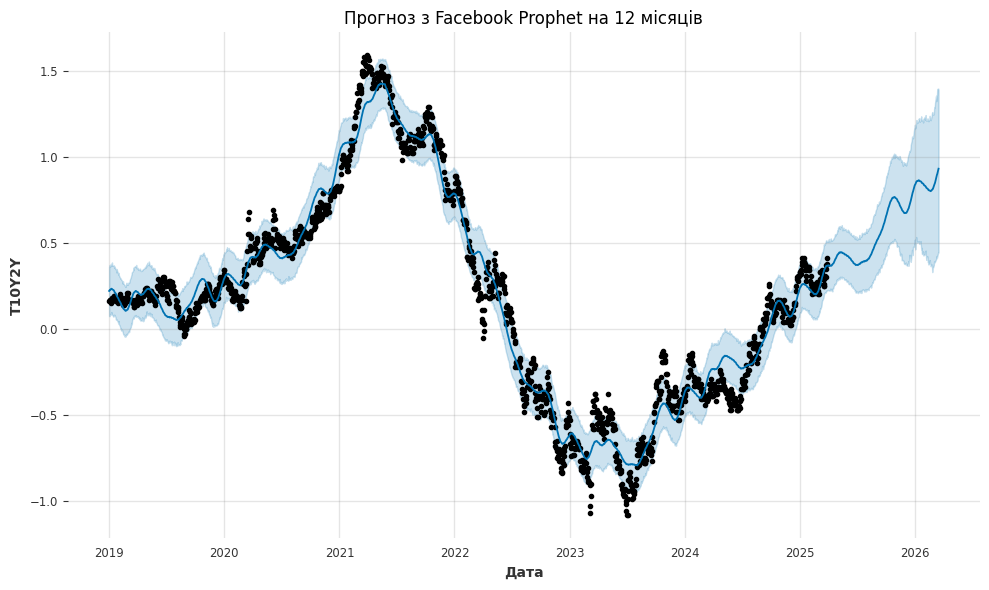

In [ ]:
# Прогноз на 12 місяців і побудова графіка

future = model.make_future_dataframe(periods=252, freq="B")
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("Прогноз з Facebook Prophet на 12 місяців")
plt.xlabel("Дата")
plt.ylabel("T10Y2Y")
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 **Аналіз прогнозу Prophet**

📉 Історія: видно чіткий спад з 2021 по 2023 та відновлення після 2024  
📈 Прогноз: зростання продовжується, помітна слабка сезонність  
🎯 Інтервал: поступово розширюється → більше невизначеності далі  

✅ **Висновок**: Prophet вловив загальний тренд і сезонні коливання.  
⏭ **Далі** → порівняємо із SARIMA або оцінити якість.

---

# 🧾 6. Оцінка якості

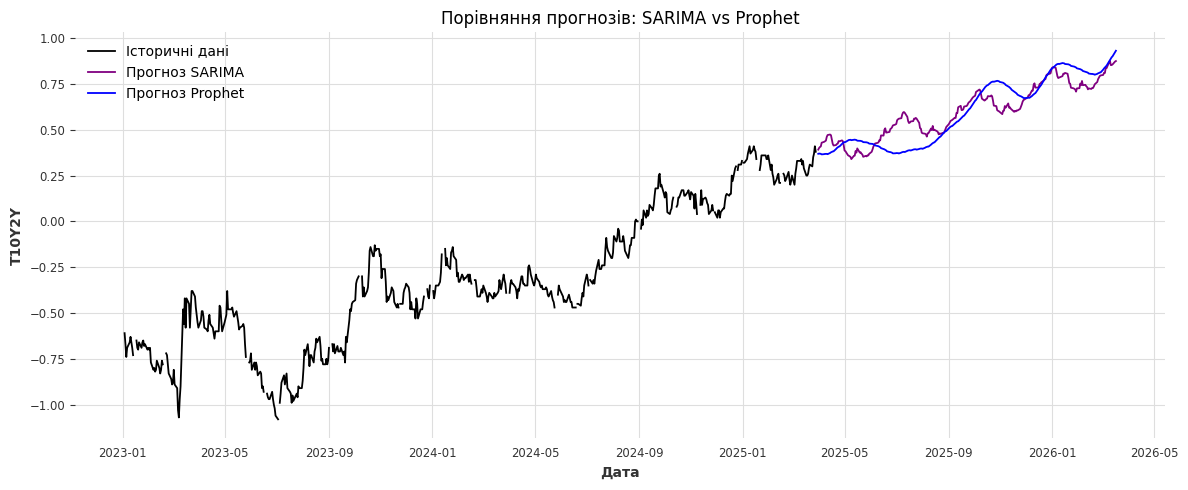

In [ ]:
# Отримуємо прогноз Prophet (тільки майбутнє)
forecast_prophet_future = forecast[forecast["ds"] > df_prophet["ds"].max()]

# Побудова графіка порівняння
plt.figure(figsize=(12, 5))

# Історичні дані
plt.plot(df_sarima.index, df_sarima["T10Y2Y"], label="Історичні дані", color="black")

# SARIMA
plt.plot(forecast_index, forecast_values, label="Прогноз SARIMA", color="purple")

# Prophet
plt.plot(forecast_prophet_future["ds"], forecast_prophet_future["yhat"], label="Прогноз Prophet", color="blue")

# Оформлення
plt.title("Порівняння прогнозів: SARIMA vs Prophet")
plt.xlabel("Дата")
plt.ylabel("T10Y2Y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🔍 **Аналіз порівняння прогнозів: SARIMA vs Prophet**

🟣 **SARIMA**  
– прогнозує плавне зростання з невеликою хвилястістю  
– показує помірну сезонність  

🔵 **Prophet**  
– також передбачає зростання  
– коливання більш **виражені** (вища чутливість до сезонності)  
– трохи випереджає SARIMA у фазі

📉 **Історія**  
– обидві моделі продовжують тренд останніх місяців  
– розбіжності починаються ближче до 2026 року  

---

✅ **Висновок**:  
Обидві моделі дають схожий напрямок (вгору), але Prophet більш "реагує" на локальні коливання.  

---

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Кількість точок для порівняння
n_points = 50

# Прогноз SARIMA — перші n точок
y_sarima = forecast_values.iloc[:n_points]

# Прогноз Prophet — витягуємо відповідні дати
forecast_prophet_df = forecast.set_index("ds")
y_prophet = forecast_prophet_df.loc[y_sarima.index]["yhat"]

# Функція порівняння двох серій
def compare_models(a, b):
    mae = mean_absolute_error(a, b)
    rmse = mean_squared_error(a, b) ** 0.5
    return mae, rmse

# Обчислення
mae_diff, rmse_diff = compare_models(y_sarima, y_prophet)

# Вивід
print("📊 Відмінність між прогнозами SARIMA та Prophet (перші", n_points, "точок):")
print("MAE:", round(mae_diff, 4))
print("RMSE:", round(rmse_diff, 4))


📊 Відмінність між прогнозами SARIMA та Prophet (перші 50 точок):
MAE: 0.0558
RMSE: 0.0625


# 🔍 **Фінальний висновок: порівняння SARIMA та Prophet**

📈 Обидві моделі прогнозують схожий тренд на 12 місяців уперед  
📊 Різниця між прогнозами на перших 50 точках:

- **MAE** = 0.0558 → середня різниця між значеннями моделей дуже мала  
- **RMSE** = 0.0625 → розбіжності несуттєві

✅ **Висновок**: обидві моделі дають **узгоджені результати**, відрізняються лише деталями сезонності та амплітудою.  
⏭ Можна впевнено використовувати обидві, залежно від задачі. Prophet зручніший для бізнес-інтерпретації, SARIMA — для класичної аналітики.